In [1]:
from experiments.baseheb import BaseHebbianExperiment
import argparse

In [2]:

parser = argparse.ArgumentParser(description='Biological deep learning')
    
# Basic configurations.
parser.add_argument('--is_training', type=bool, default=True, help='status')
parser.add_argument('--data_name', type=str, default="MNIST")

# Data Factory
parser.add_argument('--train_data', type=str, default="data/fashion_mnist/train-images.idx3-ubyte")
parser.add_argument('--train_label', type=str, default="data/fashion_mnist/train-labels.idx1-ubyte")
parser.add_argument('--test_data', type=str, default="data/fashion_mnist/t10k-images.idx3-ubyte")
parser.add_argument('--test_label', type=str, default="data/fashion_mnist/t10k-labels.idx1-ubyte")

# CSV files generated
parser.add_argument('--train_filename', type=str, default="data/fashion_mnist/fashion_mnist_train.csv")
parser.add_argument('--test_filename', type=str, default="data/fashion_mnist/fashion_mnist_test.csv")

# Dimension of each layer
parser.add_argument('--input_dim', type=int, default=784)
parser.add_argument('--heb_dim', type=int, default=64)
parser.add_argument('--output_dim', type=int, default=10)

# Hebbian layer hyperparameters
parser.add_argument('--heb_lr', type=float, default=0.005)
parser.add_argument('--heb_lamb', type=float, default=15)
parser.add_argument('--heb_gam', type=float, default=0.99)

# Classification layer hyperparameters
parser.add_argument('--cla_lr', type=float, default=0.001)
parser.add_argument('--cla_lamb', type=float, default=1)
parser.add_argument('--cla_gam', type=float, default=0.99)

# Shared hyperparameters
parser.add_argument('--eps', type=float, default=0.01)

# Parse arguments
args, _ = parser.parse_known_args()

C:\Users\patri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


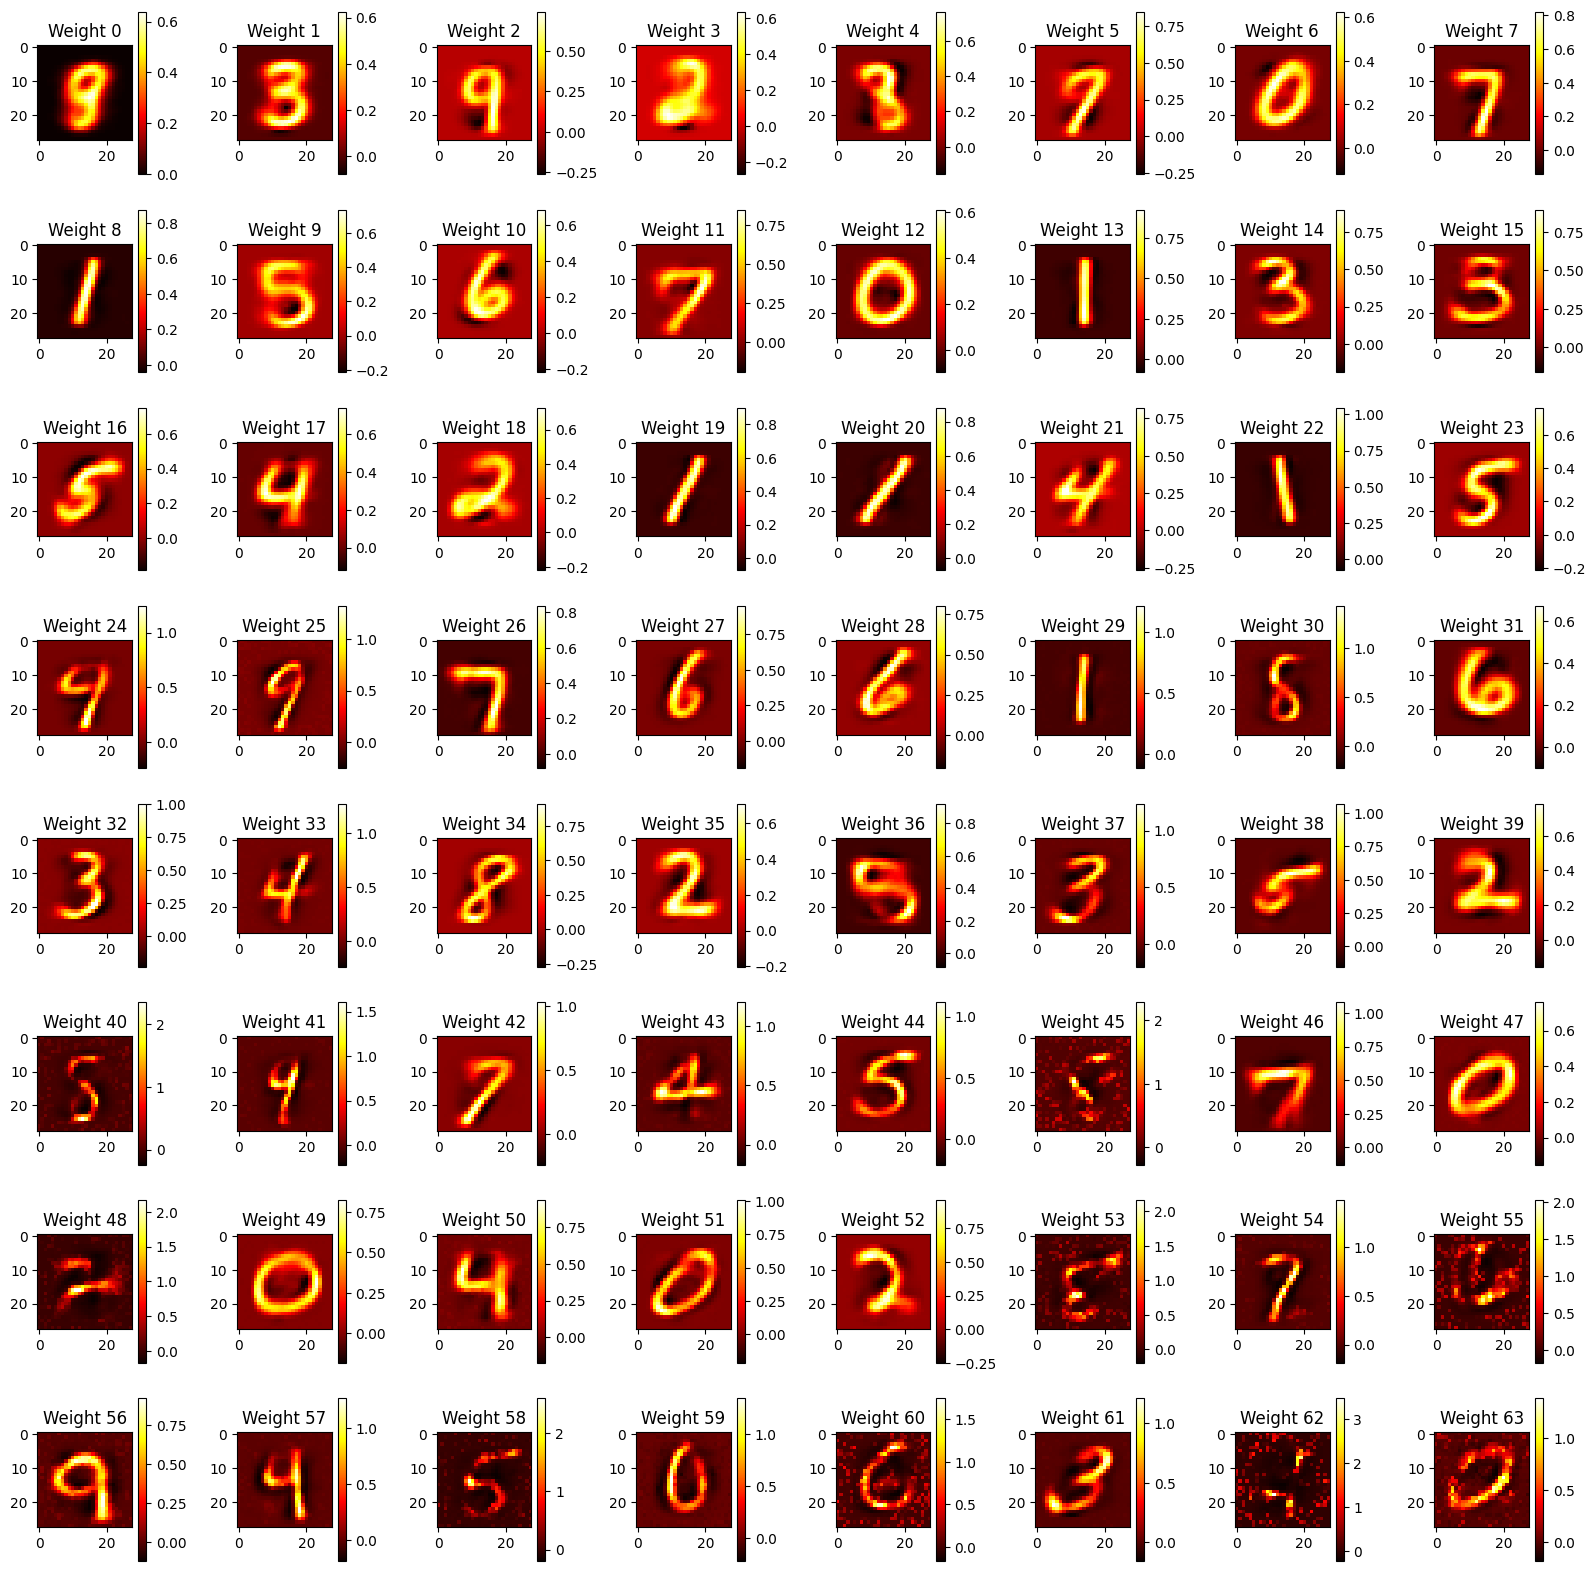

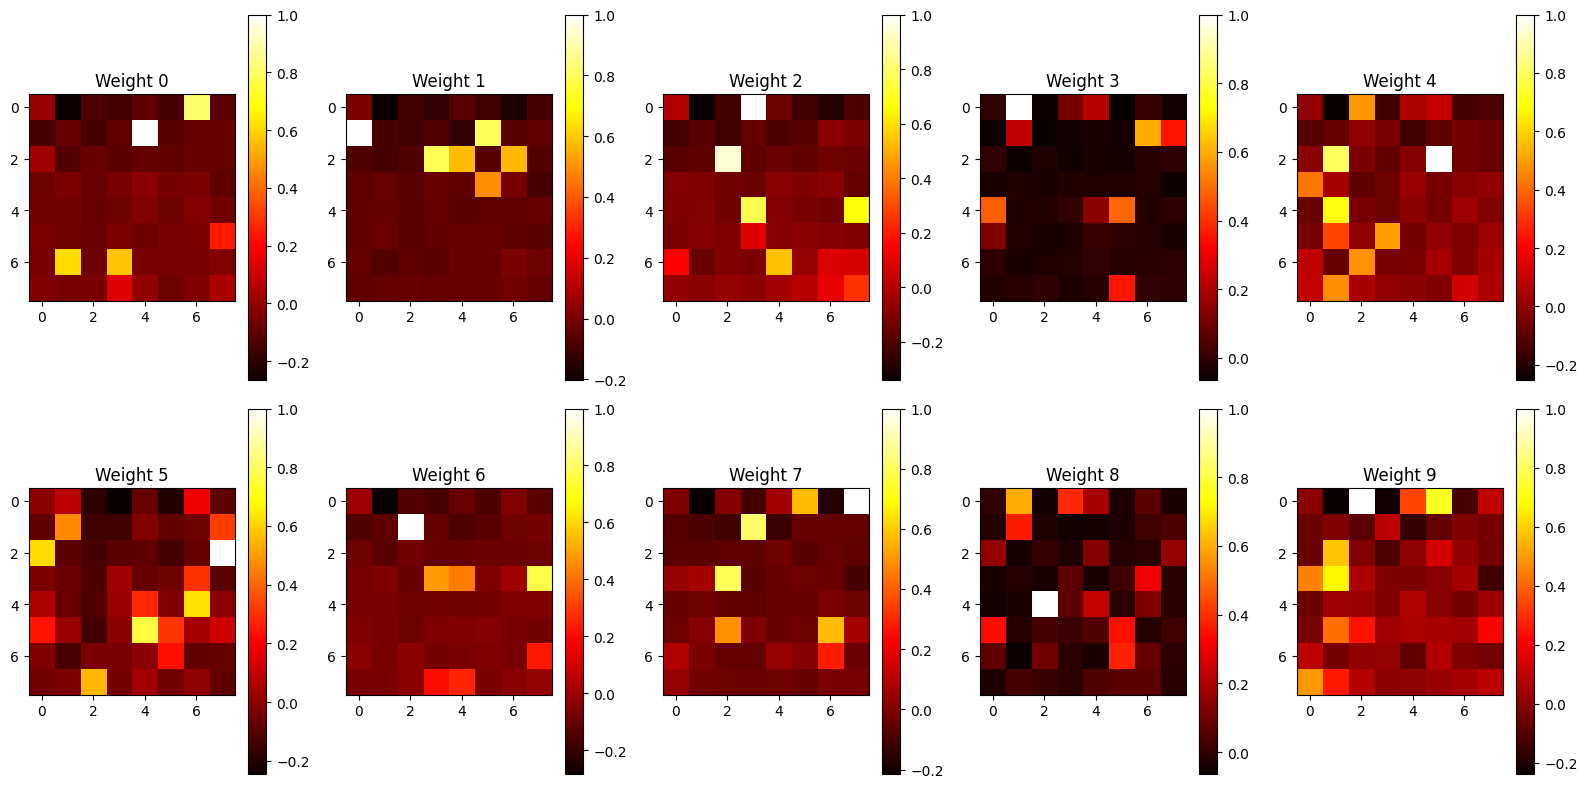

C:\Users\patri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Test Accuracy: 0.7112


In [3]:
experiment = BaseHebbianExperiment(args, num_epochs=3)
experiment.train()
experiment.visualize_weights()
print(f"Test Accuracy: {experiment.test()}")